# Week 2: Deep Neural Networks with Keras

**Group:** CCTS<br>

**Members**:
   + Chiara Maccani (2027591)
   + Samuele Piccinelli (2027650)
   + Tommaso Stentella (2027586)
   + Cristina Venturini (2022461)

We import useful libraries and dependecies:

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import time 
import math
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import csv
from IPython.display import display

plt.rc('font', family='serif', size=8)
plt.rc('mathtext', fontset='cm')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', titlesize=20)
plt.rc('figure', titlesize=15)

# 1. Convergence with a small dataset

The goal of this notebook is to train and test a fully-connected Deep Neural Network (DNN) on different datasets and to compare the so obtained results.

We first consider a dataset made of $N=3000$ samples $x[n]$, each composed of a sequence of $L_S=16$ letters representing a sequence of nucleic acid encoded in the DNA. The corresponding labels are on the other side binary: $y[n] = 1$ if $2$ unknown keys (i.e. conditions) are met and $0$ otherwise.<br>
We say that a certain model has reached convergence if the validation loss function is significantly reduced; the first test is to verify if the model is converging with a dataset small with respect to the size of each feature.

We first load the file containing the labeled samples and define the number of samples in test and train sets.

In [2]:
fname = 'DATA/sequences16.csv'
sx, sy = np.loadtxt(fname, delimiter=',', usecols=(0,1), unpack=True, dtype=str)

N, Ls = len(sy), len(sx[0])
print('Example of a labelled sample: '+sx[0], sy[0])

perc_train = 0.8
N_train = int(N*perc_train)
N_test = N - N_train
print(f'\nTotal number of samples: {N}\nSamples train set: {N_train}\nSamples test set: {N_test}')

Example of a labelled sample: AAGGTCTGCCGGCCGA 1

Total number of samples: 3000
Samples train set: 2400
Samples test set: 600


Having to deal with categorical data, we use the one-hot encoding to characterize each letter in the string to which a number has been previously associated.

In [3]:
Q = ['A', 'C', 'G', 'T']
Nc = 4
onehc = {Q[i]:i for i in range(Nc)}
print(onehc)

y = sy.astype(int)

L = Ls*Nc # number of characters in the string time the one hot length

x = np.zeros((N,L))
for n in range(N):
    for i in range(Ls):
        x[n][i*4+onehc[sx[n][i]]] = 1

{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [4]:
(x_train, y_train) = (x[:N_train], y[:N_train])
(x_test, y_test) = (x[N_train:], y[N_train:])

print('Percentage of non-null labels in the training set: {0:.3f}'.format(y_train.sum()/N_train))
print('Percentage of non-null labels in the test set: {0:.3f}'.format(y_test.sum()/N_test))

Percentage of non-null labels in the training set: 0.243
Percentage of non-null labels in the test set: 0.258


Note how the percentage of non-null labels is balanced in both sets.<br>
We define here a function `create_DNN` to instantiate and compile a DNN model given the nodes per layer, the optimizer algorithm, the activation function and the dropout rate.

In [5]:
def create_DNN(drop, activation, optimizer, nodes_per_layer=[int(L/2), int(L/4), int(L/8)]):
    # instantiate model
    model = Sequential()
    model.add(Dense(L,input_shape=(L,), activation=activation))
    for node in nodes_per_layer:
        model.add(Dense(node, activation=activation))
        if node == nodes_per_layer[-2]:
            model.add(Dropout(drop))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

To first find a reasonable architecture we performed a grid search limiting outselves to tuning the number of nodes per layer (we choose the number of hidden layers $>1$, key feature of a DNN), the dropout percentage, the optimizer algorithm and the activation function choosen among the most common.

The best model is stored in `bestNN_small` and trained on the given dataset; we will refer to this model for the following analysis as *first model* from now on.

In [6]:
nodes_per_layer = [(L/2, L/4), (L, L/2, L/4), (L/2, L/4, L/8), (L, L/2, L/4, L/8)]
drop = [0.2, 0.3, 0.4]
activation = ['relu', 'elu', 'sigmoid']
optimizer = ['SGD', 'RMSprop', 'Adam']

params = {'nodes_per_layer' : nodes_per_layer, 'drop': drop, 'activation': activation, 'optimizer': optimizer}

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=create_DNN, epochs=1)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=params, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train)

19/19 [==============================] - 0s 3ms/step - loss: 0.5794 - accuracy: 0.7667


19/19 [==============================] - 0s 3ms/step - loss: 0.6673 - accuracy: 0.7683


19/19 [==============================] - 0s 6ms/step - loss: 0.5103 - accuracy: 0.7617


19/19 [==============================] - 0s 3ms/step - loss: 0.5446 - accuracy: 0.7683


19/19 [==============================] - 0s 3ms/step - loss: 0.6019 - accuracy: 0.7667


75/75 [==============================] - 1s 3ms/step - loss: 0.5872 - accuracy: 0.7123


In [7]:
# summarize results
print("Best reached accuracy %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best reached accuracy 0.765833 using {'activation': 'elu', 'drop': 0.2, 'nodes_per_layer': (32.0, 16.0), 'optimizer': 'RMSprop'}


In [8]:
parameters=grid_result.best_params_
bestNN_small=create_DNN(parameters['drop'], parameters['activation'], parameters['optimizer'], parameters['nodes_per_layer'])

fit = bestNN_small.fit(x_train, y_train, epochs=30, batch_size=50, validation_data=(x_test,y_test), shuffle=True)

Epoch 1/30
48/48 [==============================] - 1s 16ms/step - loss: 0.5723 - accuracy: 0.7089 - val_loss: 0.5210 - val_accuracy: 0.7417
Epoch 2/30
48/48 [==============================] - 0s 7ms/step - loss: 0.5002 - accuracy: 0.7612 - val_loss: 0.5049 - val_accuracy: 0.7517
Epoch 3/30
48/48 [==============================] - 0s 7ms/step - loss: 0.5026 - accuracy: 0.7527 - val_loss: 0.4958 - val_accuracy: 0.7567
Epoch 4/30
48/48 [==============================] - 0s 7ms/step - loss: 0.4686 - accuracy: 0.7770 - val_loss: 0.4955 - val_accuracy: 0.7550
Epoch 5/30
48/48 [==============================] - 0s 7ms/step - loss: 0.4821 - accuracy: 0.7680 - val_loss: 0.5032 - val_accuracy: 0.7600
Epoch 6/30
48/48 [==============================] - 0s 6ms/step - loss: 0.4711 - accuracy: 0.7660 - val_loss: 0.4891 - val_accuracy: 0.7600
Epoch 7/30
48/48 [==============================] - 0s 7ms/step - loss: 0.4651 - accuracy: 0.7828 - val_loss: 0.4921 - val_accuracy: 0.7567
Epoch 8/30
48/48 [=

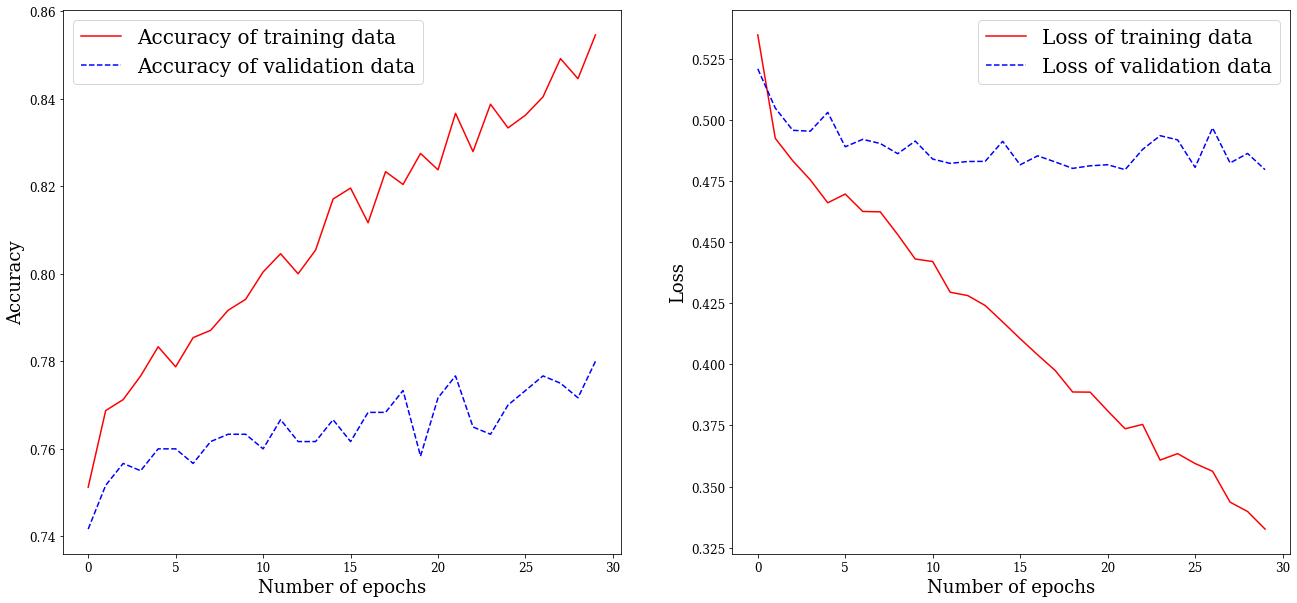

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

ax1.plot(fit.history['accuracy'], 'r', label='Accuracy of training data')
ax1.plot(fit.history['val_accuracy'], 'b--', label='Accuracy of validation data')
ax1.set_xlabel("Number of epochs", size=18)
ax1.set_ylabel("Accuracy", size=18)
ax1.legend(prop={'size': 20})

ax2.plot(fit.history['loss'], 'r', label='Loss of training data')
ax2.plot(fit.history['val_loss'], 'b--', label='Loss of validation data')
ax2.set_xlabel("Number of epochs", size=18)
ax2.set_ylabel("Loss", size=18)
ax2.legend(prop={'size': 20})
plt.show()

As it can be seen from the plots above, the loss trend is steadily (linarly) decreasing for the training set, while on the validation data it remains roughly constant and grows towards the last few epoch, suggesting a slight increase. This, together with the fact that the accuracy grows with the number of epochs on the training set while it oscillates around a fixed value of about $0.76$ for the validation set, indicates that the model is *overfitting*: the network performs better and better over the training data at each passing epoch but is unable to generalize. This is due to the fact that the network has too many parameters with respect to the number of available samples.

A possible cure to this issue is to enlarge the available dataset: that is the goal of the next section.

# 2. Augmenting the training data

In this section we enlarge the dataset: for every feature there are $L_S-1$ periodic shifts obtained by moving the last letter to the first place of the sequence. The corresponding label to the original sequence is mantained throughout the process. By doing so the number of samples goes from $N$ to $L_S\times N$: seeing the relative modest size of the small dataset the computation is done through a list comprehension and the results are stored in the `aug_x` and `aug_y` variables for features and labels respectively.

In [10]:
start_time = time.time()
aug_x = np.array([[sx[i][-x:] + sx[i][:-x] for x in range(Ls)] for i in range(N)]).flatten()
aug_y = np.array([[sy[i] for _ in range(Ls)] for i in range(N)]).flatten()
print("--- %.6s seconds ---" % (time.time() - start_time))

--- 0.0716 seconds ---


The analysis is carried out as seen before: data are divided in training and test set and the input features are one-hot encoded. Special attention is put in re-shuffling the data so that "equal labels don't lie near equal labels": when dividing data in training and test set data we make sure to have a random sequence of labels in order to guarantee a better balance between the $2$.

In [11]:
N = len(aug_y)
Ls = len(aug_x[0])

perc_train = 0.8
N_train = int(N*perc_train)
N_test = N - N_train
print(f'\nTotal number of samples: {N}\nSamples train set: {N_train}\nSamples test set: {N_test}')


Total number of samples: 48000
Samples train set: 38400
Samples test set: 9600


In [12]:
Q = ['A', 'C', 'G', 'T']
Nc = 4
onehc = {Q[i]:i for i in range(Nc)}
print(onehc)

y = aug_y.astype(int)

L = Ls*Nc

x = np.zeros((N,L))
for n in range(N):
    for i in range(Ls):
        x[n][i*4+onehc[aug_x[n][i]]] = 1

{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [13]:
aux = np.zeros((len(aug_y), Ls*4+1))
aux[:,:Ls*4] = x
aux[:,Ls*4] = y
np.random.shuffle(aux)
x = aux[:,:Ls*4]
y = aux[:,Ls*4]

(x_train, y_train) = (x[:N_train], y[:N_train])
(x_test, y_test) = (x[N_train:], y[N_train:])

print('Percentage of non-null labels in the training set: {0:.3f}'.format(y_train.sum()/N_train))
print('Percentage of non-null labels in the test set: {0:.3f}'.format(y_test.sum()/N_test))

Percentage of non-null labels in the training set: 0.246
Percentage of non-null labels in the test set: 0.246


Creating "new" samples in this way can however break the keys and provide a sample $x'[n]$ with wrong label $y[n]$. If on one hand the number of good samples fed into the DNN is enlarged, on the other a bias is introduced: we analyse this trade-off by first training the first model on the new dataset and comparing the results with the previous dataset. Then we perform a new grid search on the first $6000$ samples of the new dataset to find the best model and fit it on the whole dataset.

## 2.1 First model with the enlarged dataset <a id='another_cell'></a>

In [14]:
fit2 = bestNN_small.fit(x_train, y_train, epochs=30, batch_size=50, validation_data=(x_test,y_test), shuffle=True)

Epoch 1/30
768/768 [==============================] - 4s 5ms/step - loss: 0.4666 - accuracy: 0.7809 - val_loss: 0.4469 - val_accuracy: 0.7897
Epoch 2/30
768/768 [==============================] - 4s 5ms/step - loss: 0.4402 - accuracy: 0.7955 - val_loss: 0.4197 - val_accuracy: 0.8067
Epoch 3/30
768/768 [==============================] - 4s 5ms/step - loss: 0.4205 - accuracy: 0.8051 - val_loss: 0.4010 - val_accuracy: 0.8155
Epoch 4/30
768/768 [==============================] - 4s 5ms/step - loss: 0.3981 - accuracy: 0.8172 - val_loss: 0.3916 - val_accuracy: 0.8207
Epoch 5/30
768/768 [==============================] - 4s 5ms/step - loss: 0.3773 - accuracy: 0.8279 - val_loss: 0.3601 - val_accuracy: 0.8404
Epoch 6/30
768/768 [==============================] - 4s 5ms/step - loss: 0.3565 - accuracy: 0.8422 - val_loss: 0.3447 - val_accuracy: 0.8491
Epoch 7/30
768/768 [==============================] - 4s 5ms/step - loss: 0.3382 - accuracy: 0.8511 - val_loss: 0.3289 - val_accuracy: 0.8574
Epoch 

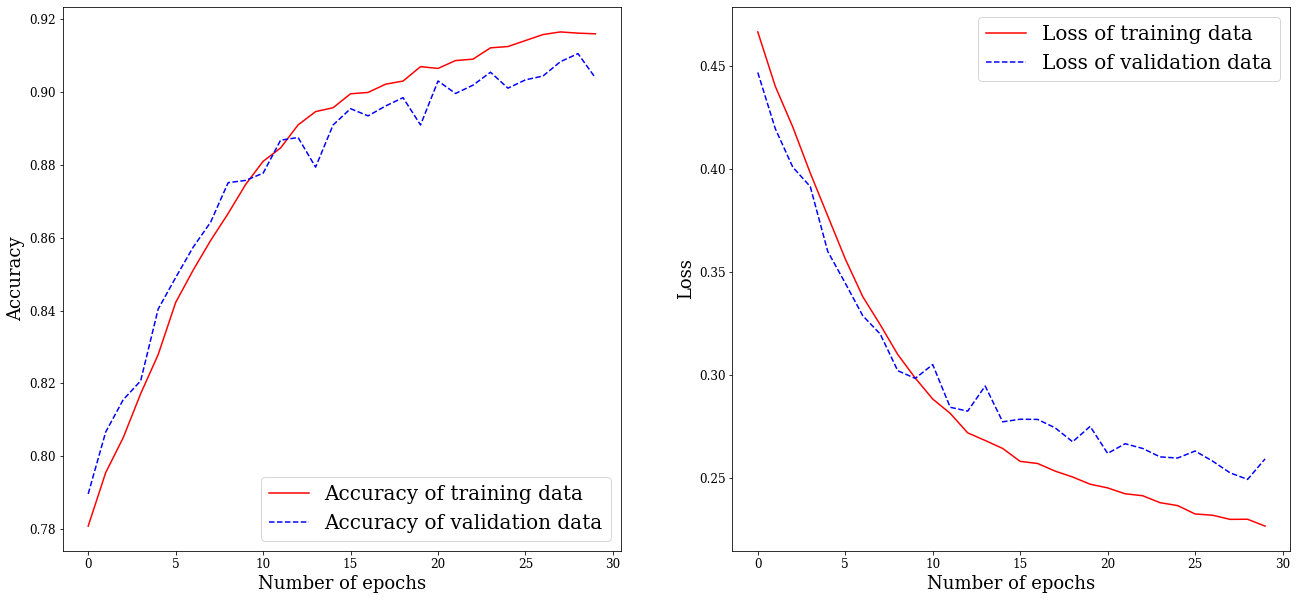

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

ax1.plot(fit2.history['accuracy'], 'r', label='Accuracy of training data')
ax1.plot(fit2.history['val_accuracy'], 'b--', label='Accuracy of validation data')
ax1.set_xlabel("Number of epochs", size=18)
ax1.set_ylabel("Accuracy", size=18)
ax1.legend(prop={'size': 20})

ax2.plot(fit2.history['loss'], 'r', label='Loss of training data')
ax2.plot(fit2.history['val_loss'], 'b--', label='Loss of validation data')
ax2.set_xlabel("Number of epochs", size=18)
ax2.set_ylabel("Loss", size=18)
ax2.legend(prop={'size': 20})
plt.show()

We first notice how the performance has improved with respect to the previous case: the accuracy is now $\sim 0.93$ for the training data and $\sim 0.91$ for the validation data, showing that there is no overfitting. While before one could clearly see that the loss on the validation was increasing, now the good correspondence between the training/validation loss trend represent a further proof of the goodness of the model.

Through this comparison, it can be stated that overall the trade-off between a small dataset of correct samples and a larger one with a few biases is positive, i.e. the same network performs decisively better with a larger dataset even if few errors are present: overfitting is avoided and convergence is reached, together with a reasonably high accuracy.

## 2.2 Grid-search on the enlarged dataset and comparison

We perform here a grid search on a restricted set of $6000$ data with the aim of improving one or more of the aspects of the model (hyper-parameters tuning). We test the architecture of the network (i.e. the number of nodes per layer), the drop-out, the activation function and the algorithm optimizers.

We proceed in a similar fashion as previously seen; we refer to this model as *second model* from now on.

In [16]:
nodes_per_layer = [(L/2, L/4), (L, L/2, L/4), (L/2, L/4, L/8), (L, L/2, L/4, L/8)]
drop = [0.2, 0.3, 0.4]
activation = ['relu', 'elu', 'sigmoid']
optimizer = ['SGD', 'RMSprop', 'Adam']

params = {'nodes_per_layer' : nodes_per_layer, 'drop': drop, 'activation': activation, 'optimizer': optimizer}

model_gridsearch = KerasClassifier(build_fn=create_DNN, epochs=1, verbose=1)

grid2 = GridSearchCV(estimator=model_gridsearch, param_grid=params, n_jobs=1, cv=4)
grid_result2 = grid2.fit(x_train[:6000],y_train[:6000])

47/47 [==============================] - 0s 2ms/step - loss: 0.4958 - accuracy: 0.7673


47/47 [==============================] - 0s 2ms/step - loss: 0.5211 - accuracy: 0.7553


47/47 [==============================] - 0s 2ms/step - loss: 0.5509 - accuracy: 0.7553


47/47 [==============================] - 0s 2ms/step - loss: 0.5461 - accuracy: 0.7640


188/188 [==============================] - 1s 3ms/step - loss: 0.5445 - accuracy: 0.7409


In [17]:
# summarize results
print("Best reached accuracy %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']

Best reached accuracy 0.770333 using {'activation': 'elu', 'drop': 0.3, 'nodes_per_layer': (64, 32.0, 16.0), 'optimizer': 'RMSprop'}


In [18]:
parameters=grid_result2.best_params_
bestNN=create_DNN(parameters['drop'], parameters['activation'], parameters['optimizer'], parameters['nodes_per_layer'])

fit3 = bestNN.fit(x_train, y_train, epochs=30, batch_size=50, validation_data=(x_test,y_test), shuffle=True)

Epoch 1/30
768/768 [==============================] - 4s 4ms/step - loss: 0.5216 - accuracy: 0.7602 - val_loss: 0.4849 - val_accuracy: 0.7708
Epoch 2/30
768/768 [==============================] - 4s 5ms/step - loss: 0.4778 - accuracy: 0.7767 - val_loss: 0.4564 - val_accuracy: 0.7847
Epoch 3/30
768/768 [==============================] - 3s 4ms/step - loss: 0.4534 - accuracy: 0.7909 - val_loss: 0.4253 - val_accuracy: 0.8011
Epoch 4/30
768/768 [==============================] - 3s 4ms/step - loss: 0.4165 - accuracy: 0.8066 - val_loss: 0.3925 - val_accuracy: 0.8233
Epoch 5/30
768/768 [==============================] - 3s 3ms/step - loss: 0.3837 - accuracy: 0.8251 - val_loss: 0.3664 - val_accuracy: 0.8373
Epoch 6/30
768/768 [==============================] - 3s 3ms/step - loss: 0.3563 - accuracy: 0.8426 - val_loss: 0.3499 - val_accuracy: 0.8450
Epoch 7/30
768/768 [==============================] - 5s 6ms/step - loss: 0.3349 - accuracy: 0.8543 - val_loss: 0.3391 - val_accuracy: 0.8537
Epoch 

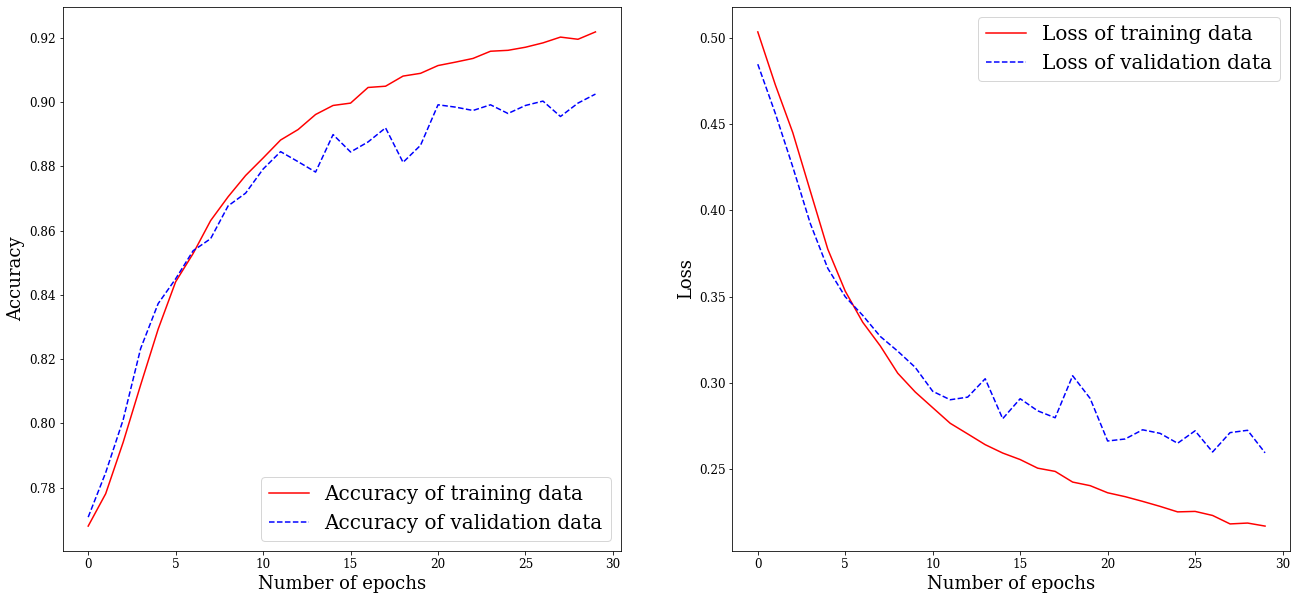

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

ax1.plot(fit3.history['accuracy'], 'r', label='Accuracy of training data')
ax1.plot(fit3.history['val_accuracy'], 'b--', label='Accuracy of validation data')
ax1.set_xlabel("Number of epochs", size=18)
ax1.set_ylabel("Accuracy", size=18)
ax1.legend(prop={'size': 20})

ax2.plot(fit3.history['loss'], 'r', label='Loss of training data')
ax2.plot(fit3.history['val_loss'], 'b--', label='Loss of validation data')
ax2.set_xlabel("Number of epochs", size=18)
ax2.set_ylabel("Loss", size=18)
ax2.legend(prop={'size': 20})
plt.show()

The performance (measured by the accuracy) is slightly worse in this case with respect to the results obtained at section [2.1](#another_cell). This is because the grid search in this case is performed on a restricted set of augmented data containing some incorrect labels and thus is not able to reach the "true" best model.<br>
When fitting the first model on augmented data, the trade-off between having a larger dataset but a few errors in the labels is positive and yields to a good result. <br>
However, in the case of the second model the grid-search is not able to actually return the best model (since it is biased by the uncorrect labels). One may think this was because we performed the grid-search on a restricted set, but we also performed it on the whole dataset and the accuracy was nonetheless inferior to the one obtained with the first model.<br>
The main difference between the two models is that the first one, when given infinite amount of samples, could theoretically obtain a zero loss, while the second one could never reach it, since it was obtained by grid-searching on data which contained errors in the labels. <br>
Nonetheless, the results obtained with the second model yield a good accuracy at a value little less than $0.90$ and the loss evolution on the validation set confirms that convergence it's still reached.

# 3. Rescaling the data

We rescale here the features $x[n] \in \{0, 1\}$ in $\{-0.5, 0.5\}$, while the labels are kept binary, since we set the activation function on the last layer to be the sigmoid and we make use of the cross-entropy as a loss function. The goal is to verify if such operation can improve the results.

In [20]:
x_train_sc = x_train - 0.5
y_train_sc = y_train
x_test_sc = x_test - 0.5
y_test_sc = y_test

## 3.1 Rescaled data on the first model

We fit the first model on the rescaled dataset; accuracy and loss are compared with the one obtained by training the same first model with the sigmoid function. Our guess is to observe an improvement in this second case due to the fact that the sigmoid activation function is "more active" in the interested interval rather than in $\{0, 1\}$.

In [21]:
fit4 = bestNN_small.fit(x_train_sc, y_train_sc, epochs=30, batch_size=50, validation_data=(x_test_sc,y_test_sc), shuffle=True)

# sigmoid
enc1 = create_DNN(drop=0.3, activation='sigmoid', optimizer='Adam', nodes_per_layer=(32, 16, 8))
fit5 = enc1.fit(x_train_sc, y_train_sc, epochs=50, batch_size=50, validation_data=(x_test_sc,y_test_sc), shuffle=True)

Epoch 1/30
768/768 [==============================] - 3s 4ms/step - loss: 0.4854 - accuracy: 0.8341 - val_loss: 0.3158 - val_accuracy: 0.8659
Epoch 2/30
768/768 [==============================] - 4s 5ms/step - loss: 0.3032 - accuracy: 0.8729 - val_loss: 0.3065 - val_accuracy: 0.8701
Epoch 3/30
768/768 [==============================] - 4s 5ms/step - loss: 0.2714 - accuracy: 0.8900 - val_loss: 0.2729 - val_accuracy: 0.8960
Epoch 4/30
768/768 [==============================] - 3s 4ms/step - loss: 0.2532 - accuracy: 0.9016 - val_loss: 0.2614 - val_accuracy: 0.9039
Epoch 5/30
768/768 [==============================] - 4s 5ms/step - loss: 0.2423 - accuracy: 0.9079 - val_loss: 0.2647 - val_accuracy: 0.9001
Epoch 6/30
768/768 [==============================] - 4s 5ms/step - loss: 0.2350 - accuracy: 0.9129 - val_loss: 0.2526 - val_accuracy: 0.9070
Epoch 7/30
768/768 [==============================] - 4s 5ms/step - loss: 0.2293 - accuracy: 0.9166 - val_loss: 0.2623 - val_accuracy: 0.9010
Epoch 

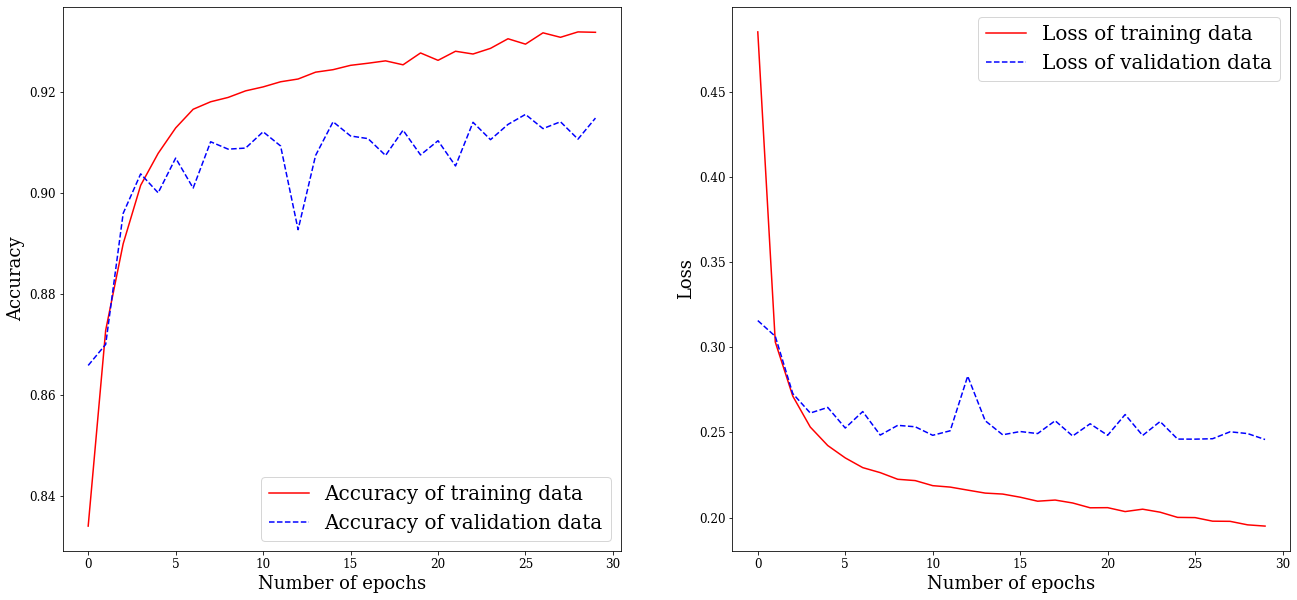

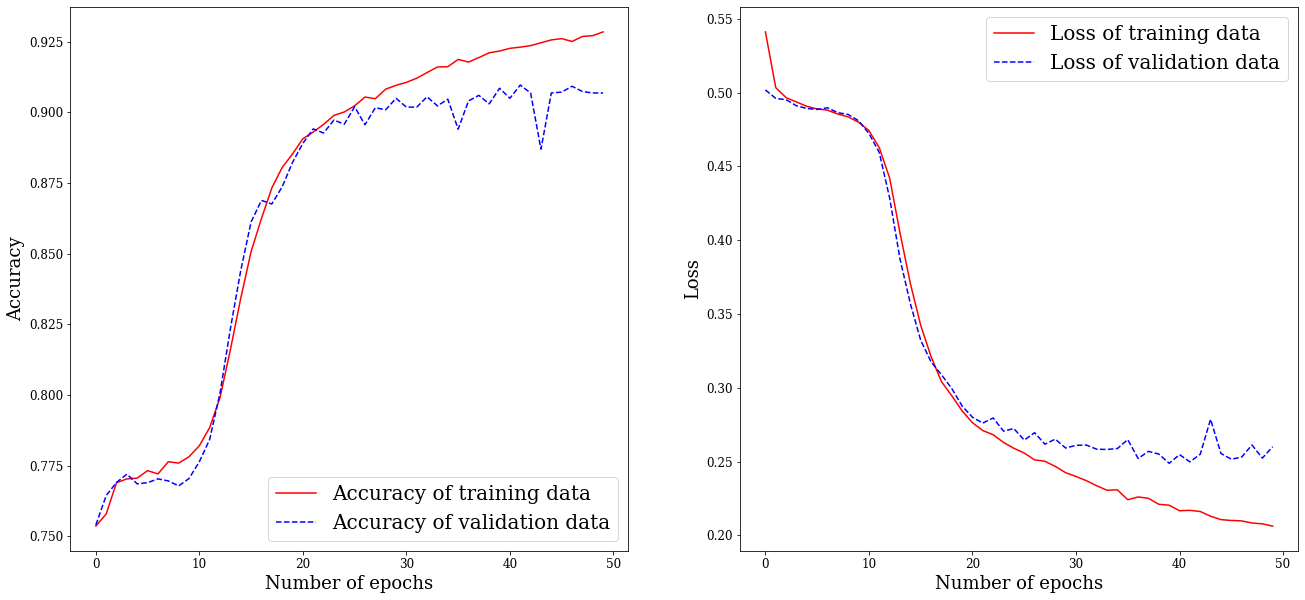

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

ax1.plot(fit4.history['accuracy'], 'r', label='Accuracy of training data')
ax1.plot(fit4.history['val_accuracy'], 'b--', label='Accuracy of validation data')
ax1.set_xlabel("Number of epochs", size=18)
ax1.set_ylabel("Accuracy", size=18)
ax1.legend(prop={'size': 20})

ax2.plot(fit4.history['loss'], 'r', label='Loss of training data')
ax2.plot(fit4.history['val_loss'], 'b--', label='Loss of validation data')
ax2.set_xlabel("Number of epochs", size=18)
ax2.set_ylabel("Loss", size=18)
ax2.legend(prop={'size': 20})
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

ax1.plot(fit5.history['accuracy'], 'r', label='Accuracy of training data')
ax1.plot(fit5.history['val_accuracy'], 'b--', label='Accuracy of validation data')
ax1.set_xlabel("Number of epochs", size=18)
ax1.set_ylabel("Accuracy", size=18)
ax1.legend(prop={'size': 20})

ax2.plot(fit5.history['loss'], 'r', label='Loss of training data')
ax2.plot(fit5.history['val_loss'], 'b--', label='Loss of validation data')
ax2.set_xlabel("Number of epochs", size=18)
ax2.set_ylabel("Loss", size=18)
ax2.legend(prop={'size': 20})
plt.show()

The plots on the top row represent the accuracy/loss coming from the first model on the rescaled dataset, while the bottom row the results coming from the first model fitted using the sigmoid activation function; as expected, the overall performance of the network is better in this second case, since the curves of both accuracy and loss of the training almost entirely overlap with the curves of the validation data, showing no signs of over- or underfitting.

Morover the accuracy remains practically unchanged from the first model evaluated on the one hot encoded dataset.

## 3.1 Rescaled data on the second model

The same process is repeated for the second model.

In [23]:
enc2 = create_DNN(drop=0.2, activation='elu', optimizer='RMSprop', nodes_per_layer=(64, 32.0, 16.0))
fit6 = enc2.fit(x_train_sc, y_train_sc, epochs=30, batch_size=50, validation_data=(x_test_sc,y_test_sc), shuffle=True)

# sigmoid
enc3 = create_DNN(drop=0.2, activation='sigmoid', optimizer='RMSprop', nodes_per_layer=(64, 32.0, 16.0))
fit7 = enc3.fit(x_train_sc, y_train_sc, epochs=40, batch_size=50, validation_data=(x_test_sc,y_test_sc), shuffle=True)

Epoch 1/30
768/768 [==============================] - 3s 3ms/step - loss: 0.5134 - accuracy: 0.7617 - val_loss: 0.4793 - val_accuracy: 0.7784
Epoch 2/30
768/768 [==============================] - 3s 3ms/step - loss: 0.4792 - accuracy: 0.7782 - val_loss: 0.4546 - val_accuracy: 0.7869
Epoch 3/30
768/768 [==============================] - 3s 4ms/step - loss: 0.4487 - accuracy: 0.7941 - val_loss: 0.4303 - val_accuracy: 0.8015
Epoch 4/30
768/768 [==============================] - 2s 3ms/step - loss: 0.4258 - accuracy: 0.8049 - val_loss: 0.4069 - val_accuracy: 0.8136
Epoch 5/30
768/768 [==============================] - 3s 4ms/step - loss: 0.3934 - accuracy: 0.8215 - val_loss: 0.3838 - val_accuracy: 0.8259
Epoch 6/30
768/768 [==============================] - 3s 3ms/step - loss: 0.3706 - accuracy: 0.8300 - val_loss: 0.3599 - val_accuracy: 0.8444
Epoch 7/30
768/768 [==============================] - 3s 4ms/step - loss: 0.3541 - accuracy: 0.8426 - val_loss: 0.3439 - val_accuracy: 0.8510
Epoch 

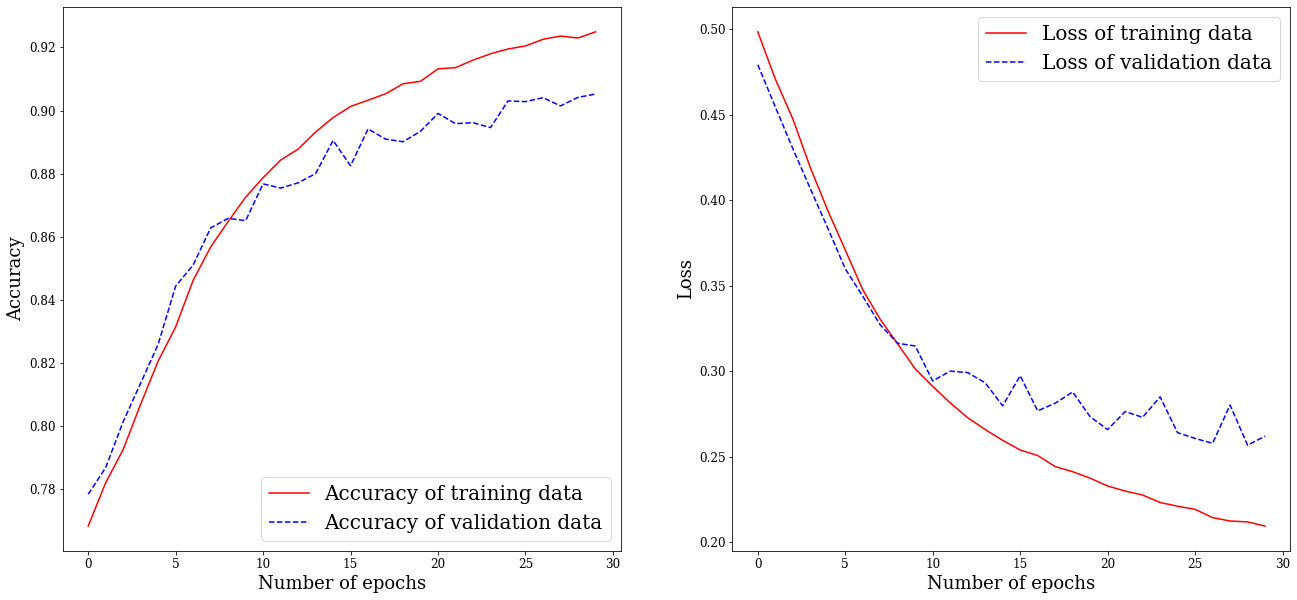

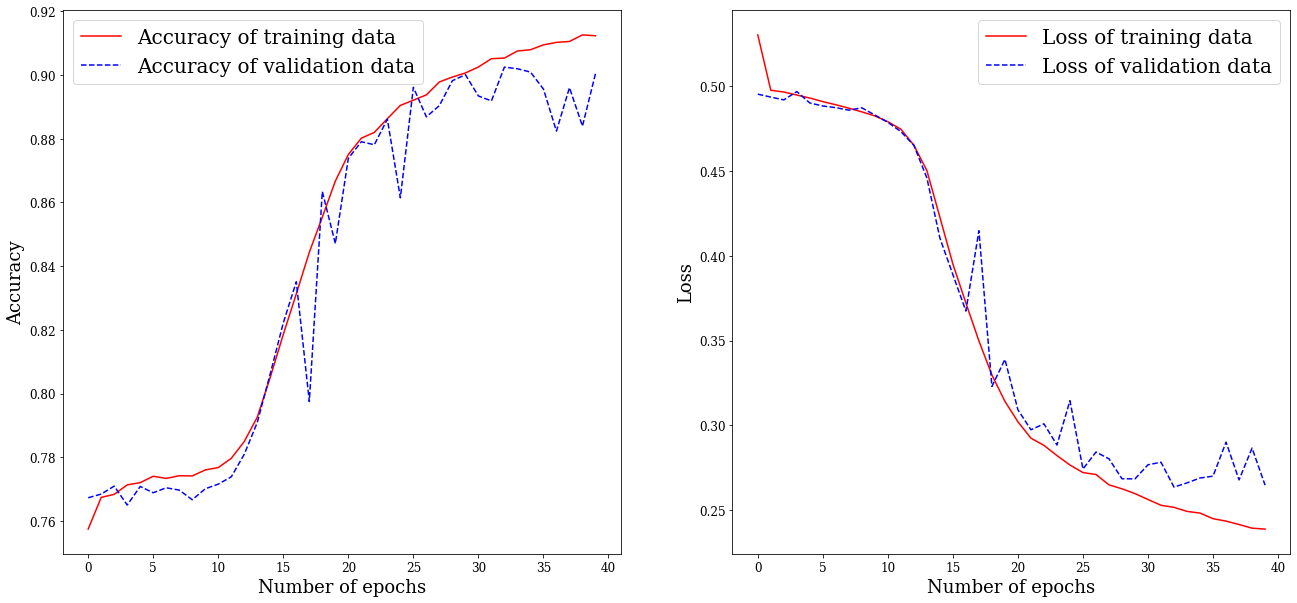

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

ax1.plot(fit6.history['accuracy'], 'r', label='Accuracy of training data')
ax1.plot(fit6.history['val_accuracy'], 'b--', label='Accuracy of validation data')
ax1.set_xlabel("Number of epochs", size=18)
ax1.set_ylabel("Accuracy", size=18)
ax1.legend(prop={'size': 20})

ax2.plot(fit6.history['loss'], 'r', label='Loss of training data')
ax2.plot(fit6.history['val_loss'], 'b--', label='Loss of validation data')
ax2.set_xlabel("Number of epochs", size=18)
ax2.set_ylabel("Loss", size=18)
ax2.legend(prop={'size': 20})
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

ax1.plot(fit7.history['accuracy'], 'r', label='Accuracy of training data')
ax1.plot(fit7.history['val_accuracy'], 'b--', label='Accuracy of validation data')
ax1.set_xlabel("Number of epochs", size=18)
ax1.set_ylabel("Accuracy", size=18)
ax1.legend(prop={'size': 20})

ax2.plot(fit7.history['loss'], 'r', label='Loss of training data')
ax2.plot(fit7.history['val_loss'], 'b--', label='Loss of validation data')
ax2.set_xlabel("Number of epochs", size=18)
ax2.set_ylabel("Loss", size=18)
ax2.legend(prop={'size': 20})
plt.show()

Similar considerations are valid also in this case.